### LSTM 

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, acf, pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout


from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import numpy as np
import pandas as pd
import sys
import warnings
import os
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

sys.path.append(os.path.abspath(os.path.join('../scripts')))
from modeling_util import *
from LSTM_helper import *
from plot_util import *
from modeling_helper import get_categorical_columns, get_numerical_columns, cross_validation, plot_result, label_encoder

#### Read the encoded data

In [11]:
df_train = pd.read_csv("../data/df_all_encoded.csv")

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   game_id             605 non-null    object 
 1   cta_start_x         605 non-null    float64
 2   cta_start_y         605 non-null    float64
 3   cta_end_x           605 non-null    float64
 4   cta_end_y           605 non-null    float64
 5   cta_height          605 non-null    float64
 6   cta_width           605 non-null    float64
 7   color_1_occurance   605 non-null    float64
 8   color_2_occurance   605 non-null    float64
 9   color_3_occurance   605 non-null    float64
 10  color_4_occurance   605 non-null    float64
 11  color_5_occurance   605 non-null    float64
 12  audio_duration(ms)  605 non-null    float64
 13  audio_intensity     605 non-null    float64
 14  audio_frame_count   605 non-null    float64
 15  beg_frame_angry     605 non-null    float64
 16  beg_fram

In [12]:
numerical_cols = get_numerical_columns(df_train)
len(numerical_cols)

41

In [13]:
df_train.drop(['game_id'], inplace=True, axis=1)

In [16]:
df_train.dtypes.value_counts()

float64    34
int64       7
dtype: int64

In [17]:
scaled_data = change_datatypes(df_train)

In [18]:
SIZE = len(scaled_data.ER)
WINDOW_SIZE = 45 
BATCH_SIZE = SIZE-WINDOW_SIZE*2
EPOCHS = 10

In [19]:
XTrain = scaled_data.ER.values[0:BATCH_SIZE].astype('float32')
XValid = scaled_data.ER.values[BATCH_SIZE:].astype('float32')
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set logarithm of sales series:  (515,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (90,)


In [21]:
tf.random.set_seed(0)
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([515, 1])

In [22]:
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [23]:
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [24]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

#### Defining and Estimating LTSM For ER(Engagement Rate) Predictor

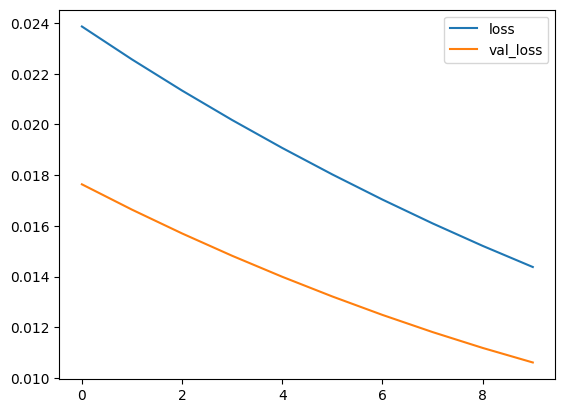

In [25]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')
history = model.fit(DatasetTrain, epochs=EPOCHS,
                    validation_data=DatasetVal, verbose=0)
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [26]:
# Set window of past points for LSTM model
window = 44

# # Split 80/20 into train/test data
last = int(len(scaled_data.ER)/5.0)
Xtrain = scaled_data.ER[:-last]
Xtest = scaled_data.ER[-last-window:]

# # Store window number of points as a sequence
xin = []
next_X = []
for i in range(window, len(Xtrain)):
    try:
        xin.append(Xtrain[i-window:i])
        next_X.append(Xtrain[i])
    except Exception as e:
        print(f'i value : {i}')
        exit(0)

# Reshape data to format for LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1)

In [27]:
# Initialize LSTM model
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [28]:
# Fit LSTM model
history = m.fit(xin, next_X, epochs=700, batch_size=50, verbose=0)

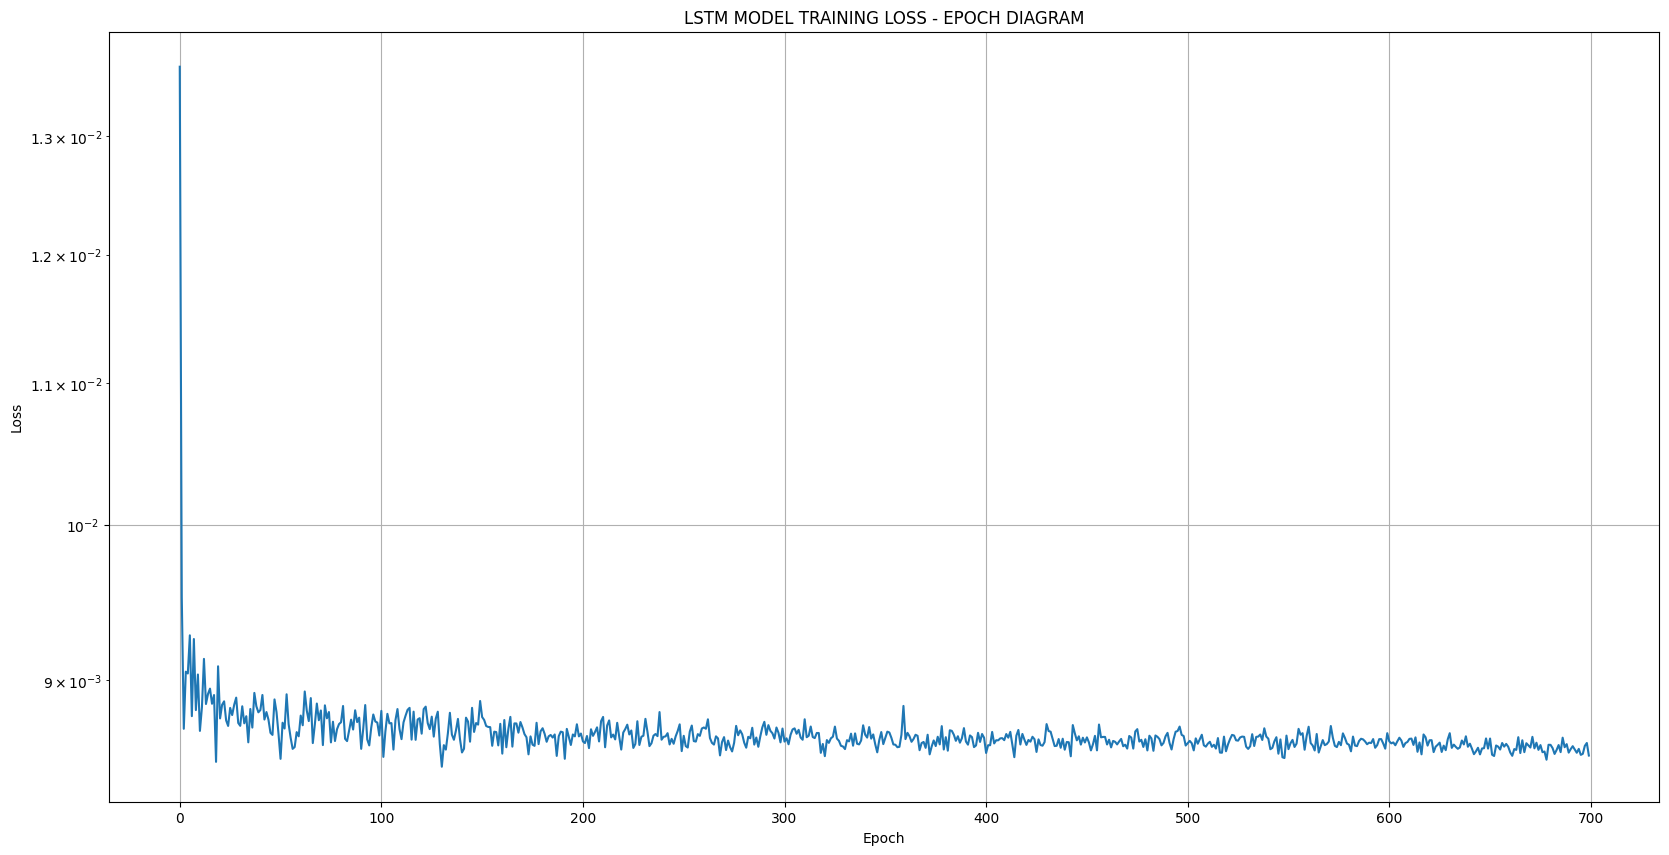

In [29]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.title('LSTM MODEL TRAINING LOSS - EPOCH DIAGRAM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])

In [30]:
# Loss value
history.history['loss'][-1]


0.008555013686418533

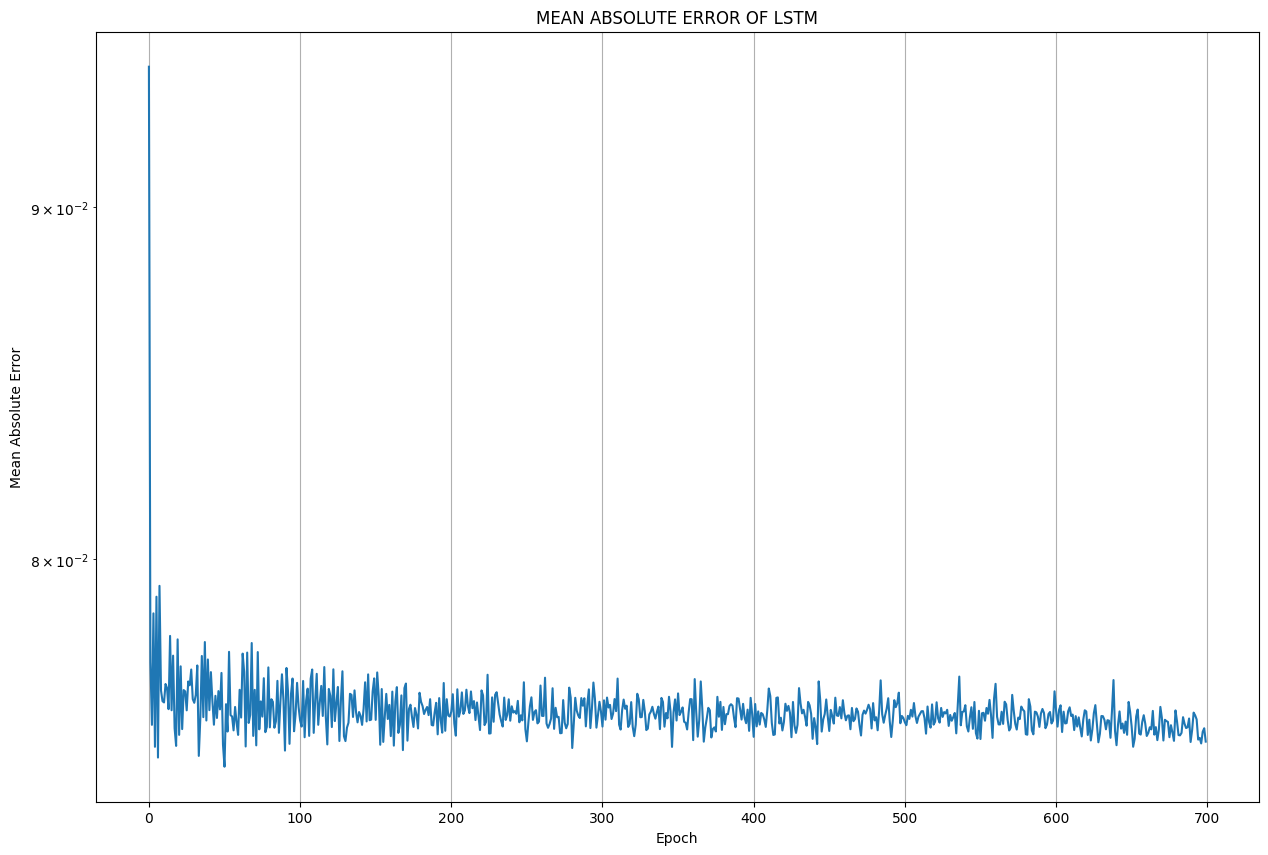

In [31]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN ABSOLUTE ERROR OF LSTM')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mae'])

In [32]:
history.history['mae'][-1]
# Last Mean Absolute Error Value

0.07526654005050659

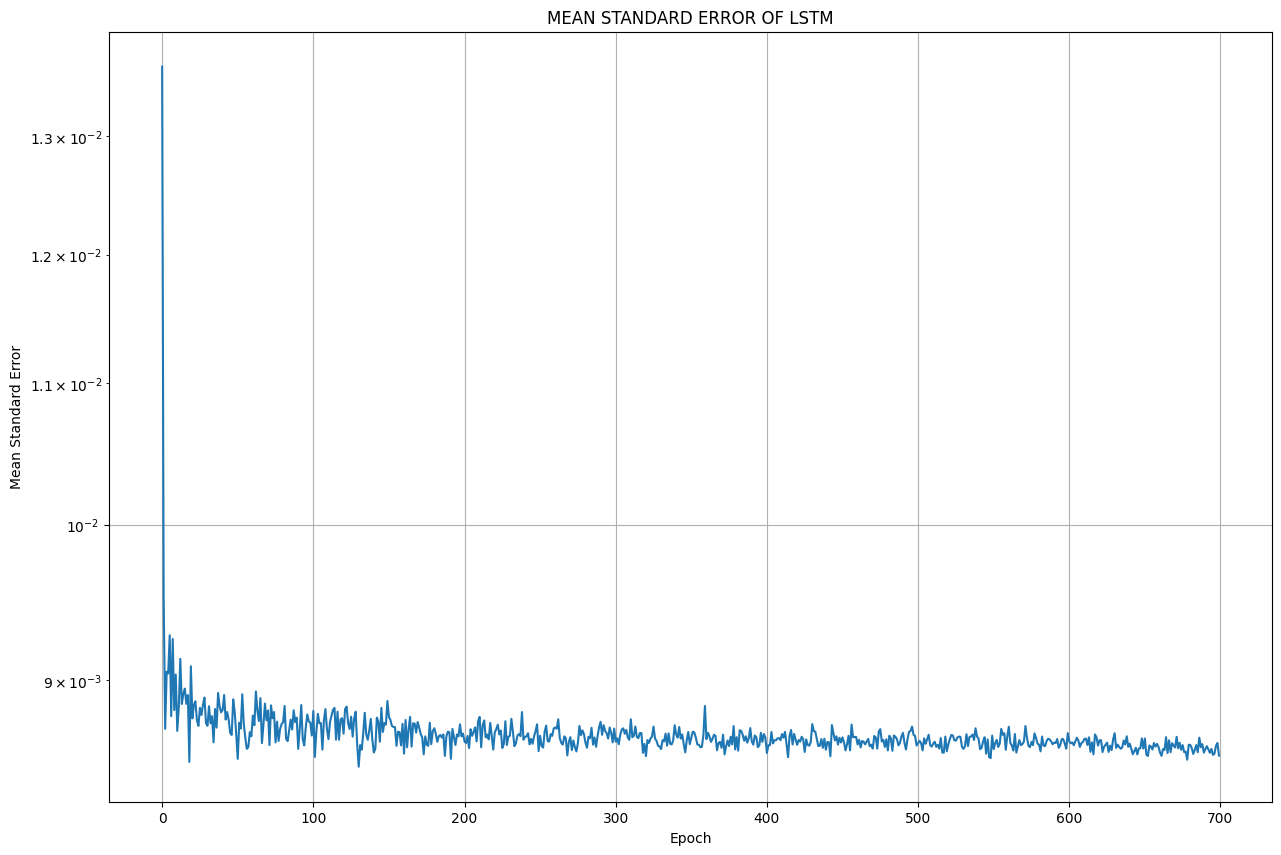

In [33]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN STANDARD ERROR OF LSTM')
plt.ylabel('Mean Standard Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mse'])

In [34]:
history.history['mse'][-1]

0.008555013686418533

In [35]:
from time import gmtime, strftime
time = strftime("%Y-%m-%d-%H:%M:%S", gmtime())
model.save(f'../models/LSTM_ER {time}.pkl')

INFO:tensorflow:Assets written to: ../models/LSTM_sales 2022-11-06-16:49:54.pkl/assets


INFO:tensorflow:Assets written to: ../models/LSTM_sales 2022-11-06-16:49:54.pkl/assets


#### LSTM fro predicting CTR(Click Through Rate)

In [44]:
scaled_data = change_datatypes(df_train)

In [45]:
SIZE = len(scaled_data.ER)
WINDOW_SIZE = 45 
BATCH_SIZE = SIZE-WINDOW_SIZE*2
EPOCHS = 10

In [47]:
XTrain = scaled_data.CTR.values[0:BATCH_SIZE].astype('float32')
XValid = scaled_data.CTR.values[BATCH_SIZE:].astype('float32')
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set logarithm of sales series:  (515,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (90,)


In [48]:
tf.random.set_seed(0)
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([515, 1])

In [49]:
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [50]:
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [52]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

#### Defining and Estimating LTSM For CTR(Click Through Rate) Predictor

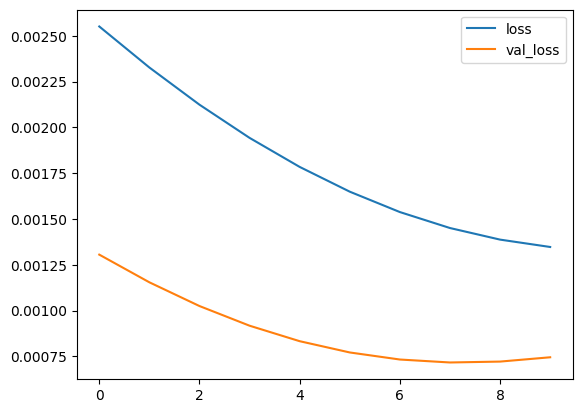

In [53]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')
history = model.fit(DatasetTrain, epochs=EPOCHS,
                    validation_data=DatasetVal, verbose=0)
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [85]:
# Set window of past points for LSTM model
window = 45

# # Split 80/20 into train/test data
last = int(len(scaled_data.CTR)/5.0)
Xtrain = scaled_data.CTR[:-last]
Xtest = scaled_data.CTR[-last-window:]

# # Store window number of points as a sequence
xin = []
next_X = []
for i in range(window, len(Xtrain)):
    try:
        xin.append(Xtrain[i-window:i])
        next_X.append(Xtrain[i])
    except Exception as e:
        print(f'i value : {i}')
        exit(0)

# Reshape data to format for LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1)

In [86]:
# Initialize LSTM model
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [87]:
# Fit LSTM model
history = m.fit(xin, next_X, epochs=700, batch_size=50, verbose=0)

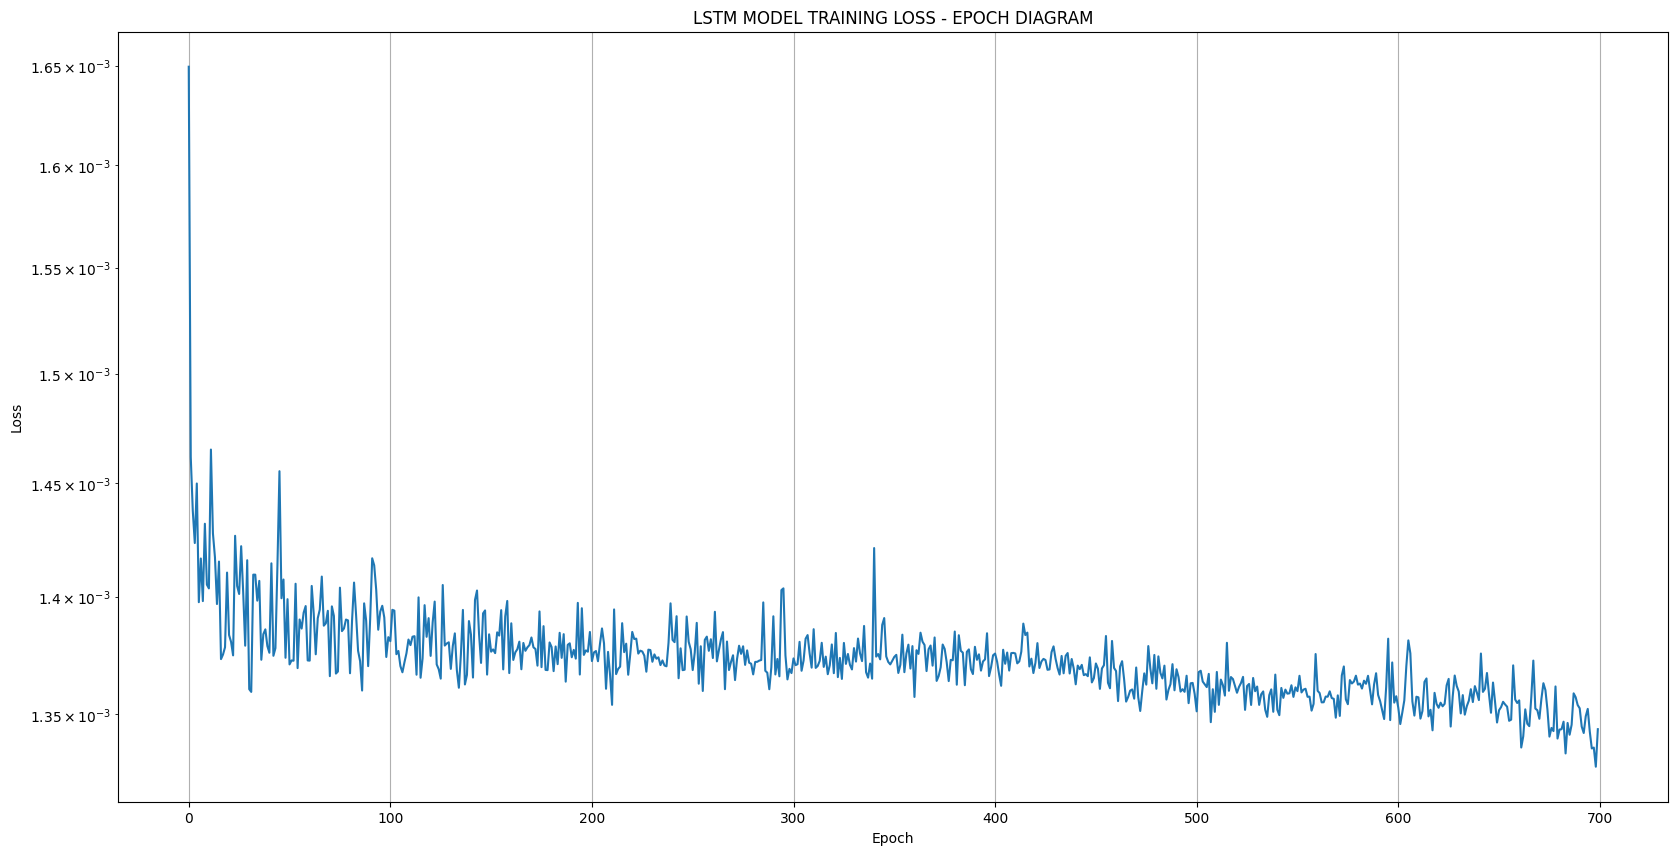

In [88]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.title('LSTM MODEL TRAINING LOSS - EPOCH DIAGRAM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])

In [89]:
history.history['loss'][-1]
# Loss value

0.001343748066574335

In [ ]:
# Xtest = scaled_data.CTR[-last-window:]
xin = []
next_X1 = []
for i in range(window, len(Xtest)):
    print(range(window, len(Xtest)))
    print(f"{i-window}:{i}")
    print(f"{window-i}:{window}")
    print(i)
    xin.append(Xtest.loc[i-window:i])
    next_X1.append(Xtest.loc[i])

# Reshape data to format for LSTM
xin, next_X1 = np.array(xin), np.array(next_X1)
xin = xin.reshape((xin.shape[0], xin.shape[1], 1))

# Predict the next value (1 step ahead)
X_pred = m.predict(xin)

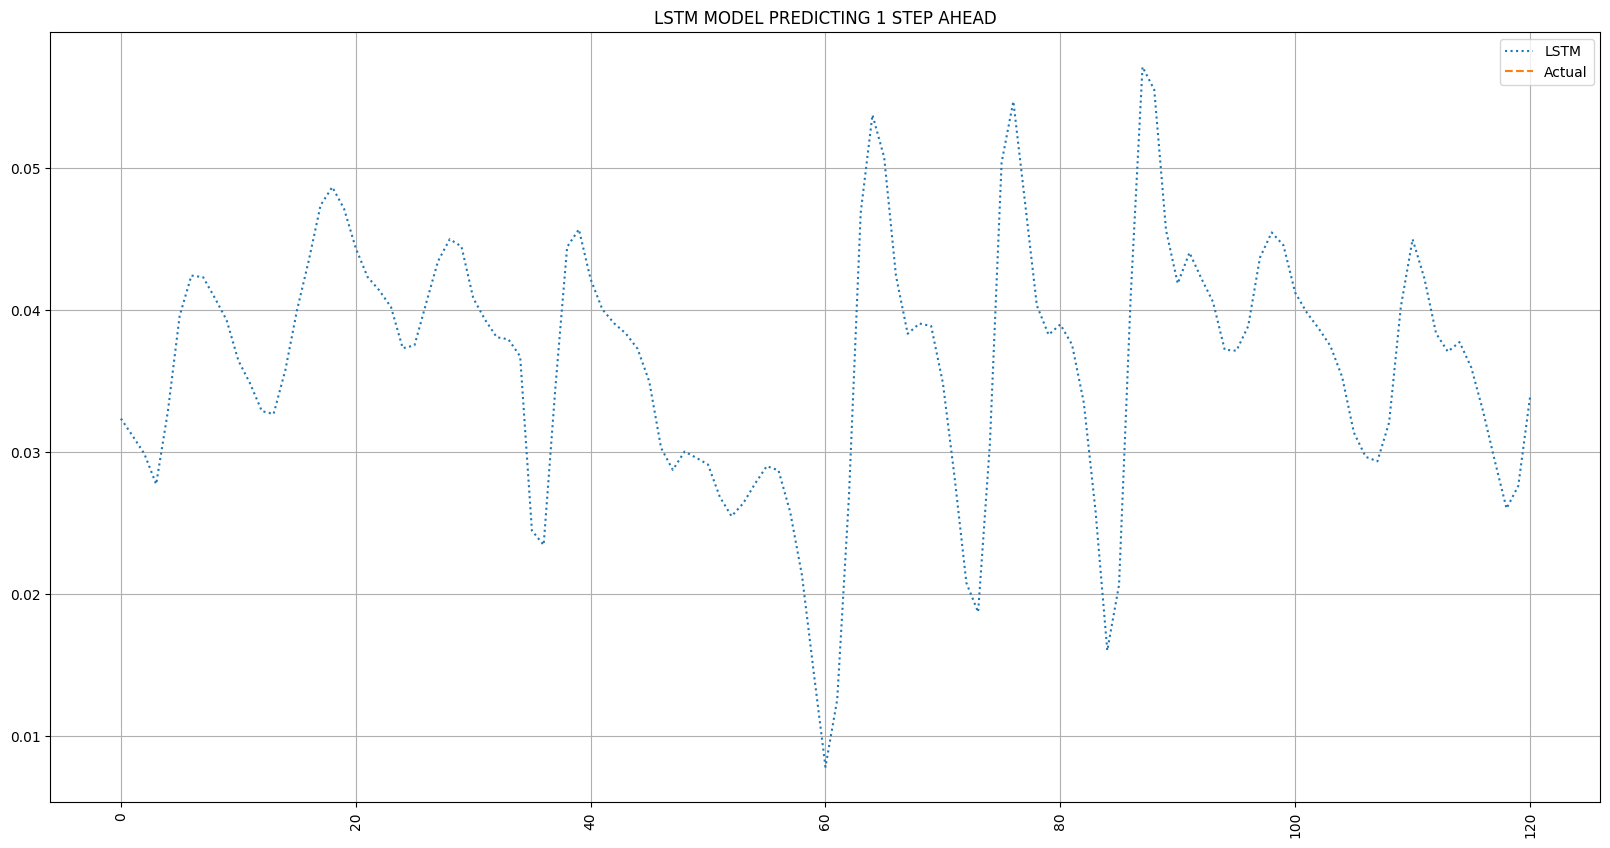

In [90]:
plt.figure(figsize=(20, 10))
plt.title('LSTM MODEL PREDICTING 1 STEP AHEAD')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred, ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()
# Plot prediction vs actual for test data


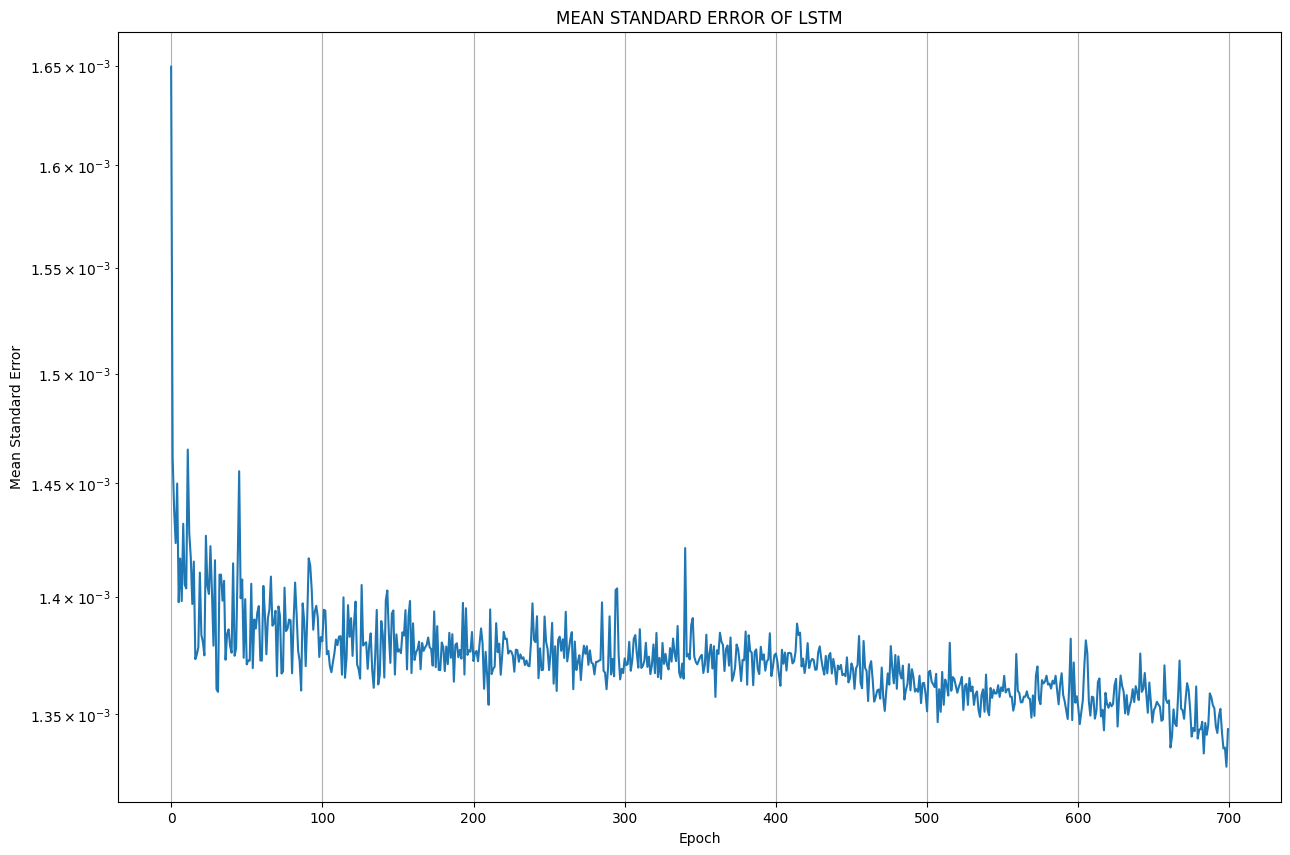

In [102]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN STANDARD ERROR OF LSTM')
plt.ylabel('Mean Standard Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mse'])

In [103]:
history.history['mse'][-1]


0.001343748066574335

#### Save Model

In [104]:
from time import gmtime, strftime
time = strftime("%Y-%m-%d-%H:%M:%S", gmtime())
model.save(f'../models/LSTM_CTR {time}.pkl')

INFO:tensorflow:Assets written to: ../models/LSTM_CTR 2022-11-06-18:22:55.pkl/assets


INFO:tensorflow:Assets written to: ../models/LSTM_CTR 2022-11-06-18:22:55.pkl/assets
